In [1]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

In [10]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display

from lpn_mrs.datasets import MRSDataset
from networks import LPN

In [20]:
import pandas as pd
test_data = pd.read_csv('../../learned-proximal-networks/data/mrs/test/Spec_001001.tsv', sep = '\t')
x = test_data['FD_Re'].values[490:1514:2].astype(np.float32)
x = torch.tensor(x).unsqueeze(0).unsqueeze(1).repeat(2,1,1)
x.shape

noise_init = 0.01
noise_final = 0.01

In [21]:
model = LPN(in_dim = 1, hidden=128, kernel=101, beta=10, alpha=1e-6)
model.load_state_dict(torch.load("../weights/test_sample/lpn_cnn_h128_k101_s0.01_lr0.0001.pth"))

<All keys matched successfully>

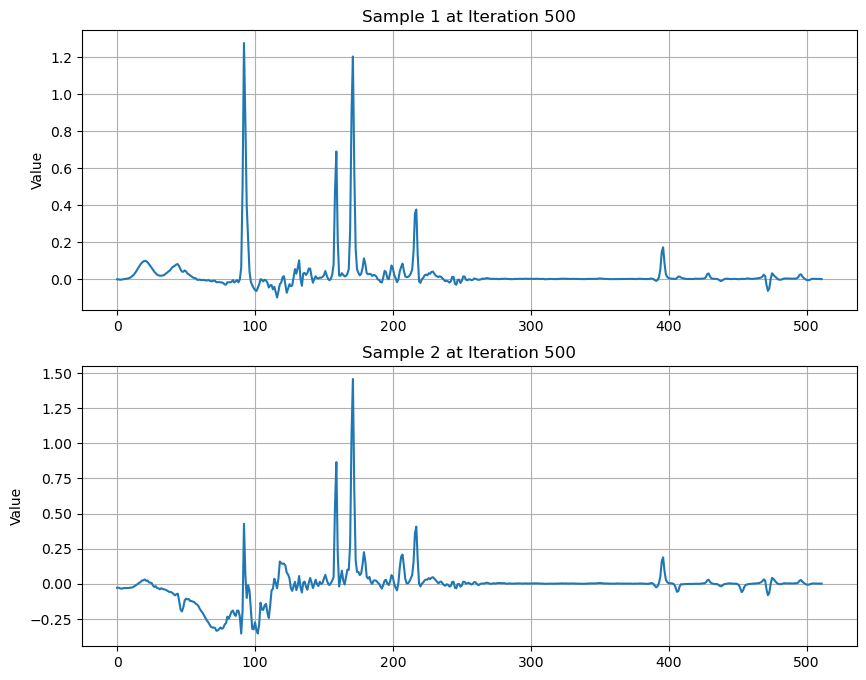

In [ ]:
plt.ion()  # Enable interactive mode for real-time plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for it in range(500):
    # noise_level = noise_init
    noise_level = noise_init * (noise_final / noise_init) ** (it / 500)
    # noise_level = noise_init - (noise_init - noise_final) * (it / 500)
    x = model(x + torch.randn_like(x) * noise_level * np.sqrt(2))
    # x = 2 * model(x + torch.randn_like(x) * noise_level / np.sqrt(2)) - x

    clear_output(wait=True)

    # Plot the first sample
    axs[0].cla()  # Clear axes
    axs[0].plot(x[0, 0].detach().numpy())  # First sample
    axs[0].set_title(f'Sample 1 at Iteration {it + 1}') 
    axs[0].set_ylabel('Value')
    axs[0].grid(True)

    # Plot the second sample
    axs[1].cla()  # Clear axes
    axs[1].plot(x[1, 0].detach().numpy())  # Second sample
    axs[1].set_title(f'Sample 2 at Iteration {it + 1}') 
    axs[1].set_ylabel('Value')
    axs[1].grid(True)

    display(fig)
    
    plt.pause(0.01)  # Wait for a brief moment to display the updated plots

# After the loop, keep the plot open
plt.ioff()  # Disable interactive mode
plt.show()

In [31]:
true_dataset = MRSDataset(root='../data', split='train')
x = np.mean(np.array([true_dataset[i] for i in range(len(true_dataset))]), axis = 0)
x = torch.tensor(x).unsqueeze(0).unsqueeze(1).repeat(2,1,1)
# x = torch.zeros_like(torch.tensor(x)).repeat(2,1,1)

noise_init = 0.03
noise_final = 0.005

In [32]:
kernel = 3
hidden = 128
sigma_min = 0.01
sigma_max = 0.01

In [33]:
model = LPN(in_dim = 1, hidden=hidden, kernel=kernel, beta=10, alpha=1e-6)
model.load_state_dict(torch.load(f"../weights/lpn_mrs_h_{hidden}_k_{kernel}_n_({sigma_min}_{sigma_max})/LPN_best.pt"))

<All keys matched successfully>

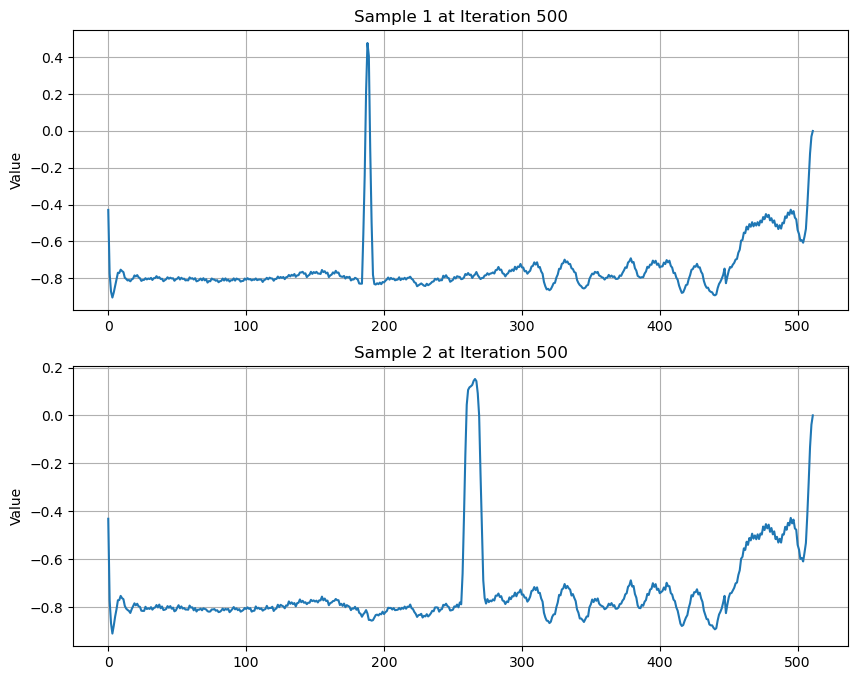

In [34]:
plt.ion()  # Enable interactive mode for real-time plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for it in range(500):
    noise_level = 0.01
    # noise_level = noise_init * (noise_final / noise_init) ** (it / 500)
    # noise_level = noise_init - (noise_init - noise_final) * (it / 500)
    x = model(x + torch.randn_like(x) * noise_level * np.sqrt(2))
    # x = 2 * model(x + torch.randn_like(x) * noise_level / np.sqrt(2)) - x

    clear_output(wait=True)

    # Plot the first sample
    axs[0].cla()  # Clear axes
    axs[0].plot(x[0, 0].detach().numpy())  # First sample
    axs[0].set_title(f'Sample 1 at Iteration {it + 1}') 
    axs[0].set_ylabel('Value')
    axs[0].grid(True)

    # Plot the second sample
    axs[1].cla()  # Clear axes
    axs[1].plot(x[1, 0].detach().numpy())  # Second sample
    axs[1].set_title(f'Sample 2 at Iteration {it + 1}') 
    axs[1].set_ylabel('Value')
    axs[1].grid(True)

    display(fig)
    
    plt.pause(0.01)  # Wait for a brief moment to display the updated plots

# After the loop, keep the plot open
plt.ioff()  # Disable interactive mode
plt.show()